In [81]:
# Built-in
from pathlib import Path

# Third-party
from matplotlib.ticker import AutoMinorLocator
from matplotlib.colors import to_rgb, to_rgba
from matplotlib import pyplot as plt
from scipy.stats import gmean
import seaborn as sns
import pandas as pd
import numpy as np
import feather
import lzma

# Local
from polya.utils import smooth
from polya.plot import custom_cmap
styles = ['../polya.mplstyle']

work = "jp3"

In [82]:
samples = {
    "ms121": ["NC2", "232", "782"],
    "ms159": ["siNC", "siLARP1", "siLARP4", "siLARP5", "sieIF4G"],
    "ms164": ["siNC", "siLARP1", "siMKRN", "siLARP4_5", "sieIF4G"],
    'jp2': ['siNC', 'siLARP1-3', 'siLARP1-S', 'siLARP44B', 'siMKRN1', 'siMKRN1siLARP1-3'],
    'jp3': ['siNC', 'siLARP1-3', 'siLARP44B', 'siMKRN1', 'siMKRN1siLARP1-3'],
}[work]

subsamples = samples[:2]
subsamples = ['siNC', 'siLARP1-3']

ctrl = {
}.get(work, samples[0])

In [83]:
workdir = Path("/casa/joha/projects/jp/works/")

panels = {
    s: pd.read_msgpack(lzma.open(workdir/work/"tagcounts/{}-single-U-canonical.msgpack.xz".format(s), "rb"))
    for s in samples
} # pd.read_msgpack is deprecated in the >0.25.0 version of pandas

/utp/joha/miniconda3/envs/polya/lib/python3.7/site-packages/pandas/io/packers.py:187: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  unpacked_obj = list(unpack(fh, encoding=encoding, **kwargs))


Get gene lists for marking specific subsets

In [69]:
genepath = "/casa/joha/scripts/tailseeker3.1.7/refdb/level3/GRCh38/annotations-gene.feather"
df_gene = feather.read_dataframe(genepath)

# Mitochondrially-encoded genes
df_mtgenes = df_gene[df_gene["seqname"].map(lambda x: x == "chrM" if x else False)]
mtgenes = df_mtgenes["gene_id"]
mtgenes = mtgenes.append(pd.Series(['ENSG00000247627.2', 'ENSG00000248527.1']) ) # adding MTND4P12, MTATP6P1 pseudogenes
print( len(mtgenes), "MT-encoded genes")

# TOP genes: The list is from Yamashita et al., NAR, 2008
topglist = [g.strip().upper() for g in open("../data/external/human_top_genes_nar_2008.csv", "rt").readlines()]
df_topgenes = df_gene[df_gene["gene_name"].isin(topglist)]
topgenes = df_topgenes["gene_id"]
print( len(topgenes), "TOP genes" )

# RP genes
df_rpgenes = df_gene[df_gene["gene_description"].map(lambda x: x.startswith("ribosomal protein") if x else False)]
df_rpgenes = df_rpgenes[df_rpgenes["gene_description"].map(lambda x: "kinase" not in x)]
df_rpgenes = df_rpgenes[df_rpgenes["gene_description"].map(lambda x: "like" not in x)]
df_rpgenes = df_rpgenes[df_rpgenes["gene_description"].map(lambda x: "binding" not in x)]
print(len(df_rpgenes), "RP genes")
rpgenes = df_rpgenes["gene_id"]

gene_subsets = {
    'mtgenes': mtgenes,
    'topgenes': topgenes,
    'rpgenes': rpgenes,
}

39 MT-encoded genes
89 TOP genes
1177 RP genes


/utp/joha/miniconda3/envs/polya/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


Color settings

In [70]:
# colors by sample
colors_by_smp = { 
    'mock': '#000000',
    'siNC': '#222222',
    'Input': '#222222',
    
    'LARP1': '#DD3224',
    'siLARP1': '#DD3224',
    'siLARP1-3': '#DD3224',
    'siLARP1-S': '#FF0524',
    
    'LARP4': '#F4D348',
    'LARP5': '#93C01F',
    'siLARP4_5': '#93C01F',
    'siLARP44B': '#93C01F',
    
    'sieIF4G': '#071AF5',
    'eIF4G1': '#071AF5',
    
    'siMKRN': '#F4D348',
    'siMKRN1': '#F4D348',
    'siMKRN1siLARP1-3': '#0750A5',
    'PABP': '#0750A5',
    
    'mtgenes': '#FF8B00',
#     'topgenes': '#246004',
    'topgenes': '#273AE2',
}


### Global poly(A)-tail length distribution

../plots/global_pAlen_dists_jp3_10-220_wo_mtgenes_mini.pdf


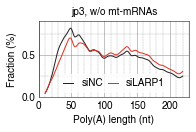

In [82]:
## Configurations
savefig = True
minifig = True
smoothing = True
pAlen_range = [10, 220]; pr = pAlen_range
smoothing_window = 15
# figsize = 5, 3.5
figsize = 5.4, 2.8 # for Fig. 4a
drop_subsets=['mtgenes']

fmax = None # Maximum value of the fraction

if minifig is True:
    styles.append("../mini.mplstyle")
    figsize = list(map(lambda x:x/2, figsize))
    
with plt.style.context(styles):
    default_colors = sns.color_palette()
    colors = [colors_by_smp.get(smp, default_colors[si]) for si, smp in enumerate(subsamples)]
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    for si, smp in enumerate(subsamples):
        pn = panels[smp]
    
        # Exlucde specific subsets of genes
        if drop_subsets:
            for subset in drop_subsets:
                pn = pn.drop(gene_subsets[subset], errors='ignore')

        if not pAlen_range: pAlen_range = [0, pn.shape[1]-1]
        
        # Normalization
        pAtags = pn.sum(axis=0).sum(axis=1).iloc[pr[0]:pr[1]+1]
        pAlen_dist = pAtags / pAtags.sum() * 100 # fraction in percent

        # Smoothing
        if smoothing is True:
            pAlen_dist = smooth(np.array(pAlen_dist), window_len=smoothing_window)

        if fmax is None: fmax = pAlen_dist.max()
        elif fmax < pAlen_dist.max(): fmax = pAlen_dist.max()
            
        if smp == 'siLARP4_5': label = 'siLARP4/4B'
        elif smp == 'siLARP1-3': label = 'siLARP1'
        else: label = smp

        ## Plotting
        if colors: ax.plot(np.arange(pr[0], pr[1]+1), pAlen_dist, color=colors[si], label=label, zorder=7)
        else: ax.plot(np.arange(pr[0], pr[1]+1), pAlen_dist, label=label, zorder=7)

    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2)) 
    ax.xaxis.grid(True, which='major', color='#878787', linestyle='-', lw=0.5)
    ax.xaxis.grid(True, which='minor', color='#878787', linestyle='--', lw=0.3)
    ax.yaxis.grid(True, which='major', color='#878787', linestyle='-', lw=0.5)
    ax.yaxis.grid(True, which='minor', color='#878787', linestyle='--', lw=0.3)
    ax.set_xlim([0,230])
    ax.set_xticks(np.arange(0,230,50))
#     ax.set_ylim([0, np.round(fmax * 1.1, 1)])
    ax.set_ylim([0,0.9])
#     ax.legend(loc="upper right", fontsize="medium")#, ncol=2, columnspacing=0.1)
    ax.legend(loc="lower center", fontsize="medium", ncol=2, handlelength=1.0, columnspacing=0.5)
    ax.set_xlabel("Poly(A) length (nt)")
    ax.set_ylabel("Fraction (%)")
    title = "{}".format(work) if 'mtgenes' not in drop_subsets else "{}, w/o mt-mRNAs".format(work)
    ax.set_title(title, fontsize="medium")
    
    fname_adduct = ""
    if 'mtgenes' in drop_subsets: fname_adduct += "_wo_mtgenes"
    if minifig is True: fname_adduct += "_mini"

    if savefig is True:
        outfigpath = "../plots/global_pAlen_dists_{}_{}-{}{}.pdf".format(work, pr[0], pr[1], fname_adduct)
        print(outfigpath)
        fig.savefig(outfigpath, dpi=300, bbox_inches="tight")

    plt.show()





### Global poly(A)-tail length distribution - show subsets separately

In [7]:
glstatsPath = "/casa/joha/projects/jp/works/{}/stats/genelevelstats-GRCh38-single.csv".format(work)
df_glstats = pd.read_csv(glstatsPath, index_col=0)
print( len(df_glstats) )

perc = 1

14700


abundant genes (top 5%)

/utp/joha/miniconda3/envs/polya/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
/utp/joha/miniconda3/envs/polya/lib/python3.7/site-packages/pandas/core/indexing.py:1207: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  copy=True, allow_dups=True)


../plots/global_pAlen_dists_ms121_10-220_top1p_wo_mtgenes_mini.pdf


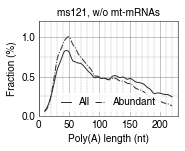

In [102]:
## Configurations
savefig = True
minifig = True
smoothing = True
pAlen_range = [10, 220]; pr = pAlen_range
smoothing_window = 15
figsize = 5, 3.5

# figsize = 5.2, 2.5 # for Fig. 4a
drop_subsets=['mtgenes']

fmax = None # Maximum value of the fraction

if minifig is True:
    styles.append("../mini.mplstyle")
    figsize = list(map(lambda x:x/2, figsize))
    
with plt.style.context(styles):
    default_colors = sns.color_palette()
    colors = [colors_by_smp.get(smp, default_colors[si]) for si, smp in enumerate(subsamples)]
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    for si, smp in enumerate(subsamples):
        pn = panels[smp]
            
        # Exlucde specific subsets of genes
        if drop_subsets:
            for subset in drop_subsets:
                pn = pn.drop(gene_subsets[subset], errors='ignore')

        if not pAlen_range: pAlen_range = [0, pn.shape[1]-1]
            
        # Get the top 5% highly expressed gene list
        tagcnt = (df_glstats[f"{smp}:polyA_tag_count"] + df_glstats[f"{smp}:nonpolyA_tag_count"]).dropna().sort_values(ascending=False)
        top5pgenes = tagcnt.iloc[:int(len(tagcnt) * (perc/100))].index
        pn_top5p = pn.loc[top5pgenes]
        
        # Normalization
        pAtags = pn.sum(axis=0).sum(axis=1).iloc[pr[0]:pr[1]+1]
        pAlen_dist = pAtags / pAtags.sum() * 100 # fraction in percent
        
        pAtags_top5p = pn_top5p.sum(axis=0).sum(axis=1).iloc[pr[0]:pr[1]+1]
        pAlen_dist_top5p = pAtags_top5p / pAtags_top5p.sum() * 100 

        # Smoothing
        if smoothing is True:
            pAlen_dist = smooth(np.array(pAlen_dist), window_len=smoothing_window)
            pAlen_dist_top5p = smooth(np.array(pAlen_dist_top5p), window_len=smoothing_window)

        if fmax is None: fmax = pAlen_dist.max()
        elif fmax < pAlen_dist.max(): fmax = pAlen_dist.max()
            
        if smp == 'siLARP4_5': label = 'siLARP4/4B'
        elif smp == 'siLARP1-3': label = 'siLARP1'
        else: label = smp

        ## Plotting
        if colors: 
            ax.plot(np.arange(pr[0], pr[1]+1), pAlen_dist, color=colors[si], label="All", zorder=7)
            ax.plot(np.arange(pr[0], pr[1]+1), pAlen_dist_top5p, color=colors[si], label='Abundant', ls='-.')
        else: 
            ax.plot(np.arange(pr[0], pr[1]+1), pAlen_dist, label=label, zorder=7)
            ax.plot(np.arange(pr[0], pr[1]+1), pAlen_dist_top5p, label='Abundant', ls='-.')
            
        

    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2)) 
    ax.xaxis.grid(True, which='major', color='#878787', linestyle='-', lw=0.5)
    ax.xaxis.grid(True, which='minor', color='#878787', linestyle='--', lw=0.3)
    ax.yaxis.grid(True, which='major', color='#878787', linestyle='-', lw=0.5)
    ax.yaxis.grid(True, which='minor', color='#878787', linestyle='--', lw=0.3)
    ax.set_xlim([0,230])
    ax.set_xticks(np.arange(0,230,50))
#     ax.set_ylim([0, np.round(fmax * 1.1, 1)])
    ax.set_ylim([0,1.2])
#     ax.legend(loc="upper right", fontsize="medium")#, ncol=2, columnspacing=0.1)
    ax.legend(loc="lower center", fontsize="medium", ncol=2, handlelength=1.0, columnspacing=0.5)
    ax.set_xlabel("Poly(A) length (nt)")
    ax.set_ylabel("Fraction (%)")
    title = "{}".format(work) if 'mtgenes' not in drop_subsets else "{}, w/o mt-mRNAs".format(work)
    ax.set_title(title, fontsize="medium")
    
    fname_adduct = f"_top{perc}p"
    if 'mtgenes' in drop_subsets: fname_adduct += "_wo_mtgenes"
    if minifig is True: fname_adduct += "_mini"

    if savefig is True:
        outfigpath = "../plots/global_pAlen_dists_{}_{}-{}{}.pdf".format(work, pr[0], pr[1], fname_adduct)
        print(outfigpath)
        fig.savefig(outfigpath, dpi=300, bbox_inches="tight")

    plt.show()





### Global poly(A)-tail length distribution scaled by relative abuandance

In [83]:
glstatsPath = "/utp/joha/projects/jp/works/{}/stats/genelevelstats-GRCh38-single.csv".format(work)
df_glstats = pd.read_csv(glstatsPath, index_col=0)
print( len(df_glstats) )

# Handle AttuributeError if any
df_glstats = df_glstats.dropna(subset=["gene_description"])
print( len(df_glstats) )

17272
17272


In [84]:
mtgenes_cutoff = 1000
scaler = 1000
normed_tagcnt_cutoff = 12.5

def get_mtnormed_tagcnts(smp, df):
    global mtgenes, mtgenes_cutoff, scaler, normed_tagcnt_cutoff
    tagcnts = df[[f"{smp}:polyA_tag_count", f"{smp}:nonpolyA_tag_count"]].sum(axis=1).dropna()
    mtgenes_tagcnts = tagcnts[mtgenes]
    mtgenes_tagcnts = mtgenes_tagcnts[mtgenes_tagcnts >= mtgenes_cutoff]
    normed = tagcnts / gmean(mtgenes_tagcnts) * scaler
    
    return normed[normed >= normed_tagcnt_cutoff]

mtnormed_tagcnts_sum = dict()
for smp in samples:
    mtnormed_tagcnts_sum[smp] = get_mtnormed_tagcnts(smp, df_glstats).sum()

In [85]:
mtnormed_tagcnts_sum

{'siNC': 108526.85515418681,
 'siLARP1-3': 83445.2198734922,
 'siLARP44B': 99512.79588901541,
 'siMKRN1': 106058.7966770621,
 'siMKRN1siLARP1-3': 82171.28690680352}

../plots/global_pAlen_dists_jp3_mt-scaled_10-220_wo_mtgenes_mini.pdf


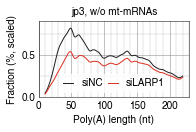

In [86]:
savefig = True
minifig = True

# figsize = 8.4,5
figsize = 5.4, 2.8
ctrl = 'siNC'
pAlen_range = [10, 220]; pr = pAlen_range
smoothing_window = 15
smoothing = True

fmax = None # Maximum value of the fraction

styles = ['../polya.mplstyle']
if minifig is True:
    styles.append('../mini.mplstyle')
    figsize = list(map(lambda x:x/2, figsize)) 
    
drop_subsets = ['mtgenes']


with plt.style.context(styles):
    default_colors = sns.color_palette()
    colors = [colors_by_smp.get(smp, default_colors[si]) for si, smp in enumerate(subsamples)]
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    for si, smp in enumerate(subsamples):
        pn = panels[smp]
    
        # Exlucde specific subsets of genes
        if drop_subsets:
            for subset in drop_subsets:
                pn = pn.drop(gene_subsets[subset], errors='ignore')

        if not pAlen_range: pAlen_range = [0, pn.shape[1]-1]
        
        # Normalization
        pAtags = pn.sum(axis=0).sum(axis=1).iloc[pr[0]:pr[1]+1]
        pAlen_dist = pAtags / pAtags.sum() * 100 # fraction in percent
        pAlen_dist = pAlen_dist * (mtnormed_tagcnts_sum[smp] / mtnormed_tagcnts_sum[ctrl])

        # Smoothing
        if smoothing is True:
            pAlen_dist = smooth(np.array(pAlen_dist), window_len=smoothing_window)

        if fmax is None: fmax = pAlen_dist.max()
        elif fmax < pAlen_dist.max(): fmax = pAlen_dist.max()
            
        if smp == 'siLARP4_5': label = 'siLARP4/4B'
        elif smp == 'siLARP1-3': label = 'siLARP1'
        else: label = smp

        ## Plotting
        if colors: ax.plot(np.arange(pr[0], pr[1]+1), pAlen_dist, color=colors[si], label=label, zorder=7)
        else: ax.plot(np.arange(pr[0], pr[1]+1), pAlen_dist, label=label, zorder=7)

    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2)) 
    ax.xaxis.grid(True, which='major', color='#878787', linestyle='-', lw=0.5)
    ax.xaxis.grid(True, which='minor', color='#878787', linestyle='--', lw=0.3)
    ax.yaxis.grid(True, which='major', color='#878787', linestyle='-', lw=0.5)
    ax.yaxis.grid(True, which='minor', color='#878787', linestyle='--', lw=0.3)
    ax.set_xlim([0,230])
    ax.set_xticks(np.arange(0,230,50))
#     ax.set_ylim([0, np.round(fmax * 1.1, 1)])
    ax.set_ylim([0,0.9])
#     ax.legend(loc="lower right", fontsize="medium")#, ncol=2, columnspacing=0.1)
    ax.legend(loc="lower center", fontsize="medium", ncol=2, handlelength=1.0, columnspacing=0.5)
#     ax.legend(loc="center left", bbox_to_anchor=[1.01,0.5])
    ax.set_xlabel("Poly(A) length (nt)")
    ax.set_ylabel("Fraction (%, scaled)")
    title = "{}".format(work) if 'mtgenes' not in drop_subsets else "{}, w/o mt-mRNAs".format(work)
    ax.set_title(title, fontsize="medium")
    
    fname_adduct = ""
    if 'mtgenes' in drop_subsets: fname_adduct += "_wo_mtgenes"
    if minifig is True: fname_adduct += "_mini"

    if savefig is True:
        outfigpath = "../plots/global_pAlen_dists_{}_mt-scaled_{}-{}{}.pdf".format(work, pr[0], pr[1], fname_adduct)
        print(outfigpath)
        fig.savefig(outfigpath, dpi=300, bbox_inches="tight")

    plt.show()

### Local poly(A) density of individual genes compared to control

In [85]:
subsamples = ['siNC', 'siLARP1-3']

In [88]:
local_range = [30, 60]; lr = local_range # Local poly(A) range to compare
pAlen_range = [10, 220]; pr = pAlen_range # Entire poly(A) range that will be considered
minimum_pAtags = 350
# minimum_pAtags = 200

def get_local_density_mean(panel, local_range=local_range, pAlen_range=pAlen_range, minimum_pAtags=minimum_pAtags):
    lr = local_range; pr = pAlen_range
    
    pAtags = panel.sum(axis=2).iloc[pr[0]:pr[1]+1, :].T
    pAtags = pAtags[pAtags.sum(axis=1) >= minimum_pAtags]
    pAlen_dist = pAtags.div(pAtags.sum(axis=1), axis='index') * 100
    
    return pAlen_dist[range(lr[0],lr[1]+1)].mean(axis=1)

pn_ctrl = panels[ctrl]
local_density_ctrl = get_local_density_mean(pn_ctrl, local_range, pAlen_range, minimum_pAtags)

df_ld = pd.DataFrame()
for smp in subsamples:
    if smp == ctrl: continue
        
    pn = panels[smp]
    local_density_mean = get_local_density_mean(pn)
    local_density_log2fold = local_density_mean.div(local_density_ctrl).dropna().map(np.log2)
    df_ld[smp] = local_density_log2fold
    
df_ld.columns = ['siLARP1']


In [89]:
nb_genes = df_ld.describe().loc['count'].astype(int)
nb_genes

siLARP1    481
Name: count, dtype: int64

combined boxplot

In [90]:
subsets = ['mtgenes']
# subsets = ['topgenes', 'mtgenes']
subset_labels = {
    'mtgenes': "Mito",
    'topgenes': "TOP",
}

df_rest = df_ld.copy()
for subset in subsets:
    df_rest = df_rest.drop(gene_subsets[subset], errors='ignore')

df_sep = pd.melt(df_rest)
df_sep.loc[:, 'category'] = 'Cytosol'

for subset in subsets:
    subset_genes = gene_subsets[subset]
    subset_label = subset_labels[subset]
    df_subset = pd.melt(df_ld.reindex(subset_genes).dropna())
    df_subset.loc[:, 'category'] = subset_label
    df_sep.drop 
    
    df_sep = pd.concat([df_sep, df_subset])

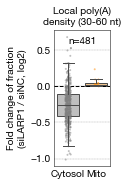

In [91]:
savefig = False
minifig = True
figsize = 2, 5
if minifig is True:
    if not minifig in styles: styles.append("../mini.mplstyle")
    figsize = list(map(lambda x:x/2, figsize))

colors = ['gray'] + [colors_by_smp[subset] for subset in subsets]
box_alpha=0.3

with plt.style.context(styles):
    fig, ax = plt.subplots(figsize=figsize)
    ax.axhline(y=0, ls="--", color='k')
        
    # Stripplot
    ax = sns.stripplot(x='category', y='value', data=df_sep, 
                       s=2, alpha=0.5, palette=[to_rgba(c) for c in colors], 
                       edgecolor='none', rasterized=True, zorder=6)
    
    # Boxplot
    ax = sns.boxplot(x='category', y='value', palette=[to_rgba(c, alpha=box_alpha) for c in colors], data=df_sep,
                     showfliers=False, zorder=7)
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, .5))
        
    ax.set_xlabel("")
    ax.set_ylabel(f"Fold change of fraction\n(siLARP1 / siNC, log2)")
    ax.text(x=0.5, y=0.9, s=f"n={nb_genes[0]}", ha='center', transform=ax.transAxes)
    ax.set_title("Local poly(A)\ndensity ({}-{} nt)".format(*local_range), fontsize='medium')
    ax.grid(axis='y')
    
    if len(subsets) > 1:
        plt.xticks(rotation=45)
        
    fname_adduct = ""
    if minifig is True:
        fname_adduct += "_mini"

    if savefig is True:
        outfigpath = "../plots/local_pAd_folds_{}_{}-{}{}.pdf".format(work, lr[0], lr[1], fname_adduct)
        plt.savefig(outfigpath, bbox_inches='tight', dpi=300)
        print( outfigpath, 'saved')

combined swarm plot

/utp/joha/miniconda3/envs/polya/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


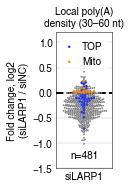

In [92]:
savefig = False
minifig = True
subsets = ['topgenes','mtgenes']
styles = ['../polya.mplstyle']
# non_ctrl = subsamples.copy()
# non_ctrl.pop(subsamples.index(ctrl))
non_ctrl = ['siLARP1']
subset_colors = [colors_by_smp[subset] for subset in subsets]
figsize = 1 + len(non_ctrl), 5
if minifig is True:
    if "../mini.mplstyle" not in styles: styles.append("../mini.mplstyle")
    figsize = list(map(lambda x:x/2, figsize))

with plt.style.context(styles):
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.axhline(y=0, ls='--', lw=2, alpha=1, color='black')
    
    # All genes but the subset
    df_rest = df_ld.drop(subset, errors='ignore')
    ax = sns.swarmplot(data=df_rest[non_ctrl], size=1.75, color='gray', ax=ax, rasterized=True)
    
    # The subset genes
    for si, subset in enumerate(subsets):
        subset_genes = gene_subsets[subset]
        scolor = subset_colors[si]
        slabel = subset_labels[subset]
        ax = sns.swarmplot(data=df_ld.loc[subset_genes, non_ctrl], size=2.5, color=scolor, label=slabel, ax=ax)

    ax.set_ylim([-1.5, 1.2])
    ax.set_ylabel(f"Fold change, log2\n(siLARP1 / {ctrl})")
    ax.set_title(f"Local poly(A)\ndensity ({lr[0]}–{lr[1]} nt)", fontsize='medium')
    ax.legend(fontsize='medium')
    ax.grid(axis='y')

    for i, cnt in enumerate(nb_genes):
        ax.text(x=i, y=-1.3, s=f'n={cnt}', ha='center')

    fname_adduct = ""
    if minifig is True:
        fname_adduct += "_mini"

    if savefig is True:
        outfigpath = "../plots/local_pAd_folds_{}_{}-{}{}.pdf".format(work, lr[0], lr[1], fname_adduct)
        plt.savefig(outfigpath, bbox_inches='tight', dpi=300)
        print( outfigpath, 'saved')

    plt.show()

In [93]:
df_ld.sort_values(by='siLARP1', ascending=False).index

Index(['ENSG00000112306.7', 'ENSG00000203950.6', 'ENSG00000073111.13',
       'ENSG00000115306.15', 'ENSG00000118705.16', 'ENSG00000215301.9',
       'ENSG00000134871.17', 'ENSG00000224631.4', 'ENSG00000116560.10',
       'ENSG00000124783.12',
       ...
       'ENSG00000105220.14', 'ENSG00000131462.7', 'ENSG00000175203.15',
       'ENSG00000172115.8', 'ENSG00000049656.13', 'ENSG00000186184.15',
       'ENSG00000106211.8', 'ENSG00000100353.17', 'ENSG00000186522.14',
       'ENSG00000119705.9'],
      dtype='object', length=481)

In [94]:
df_ld.loc['ENSG00000112306.7']

siLARP1    0.677787
Name: ENSG00000112306.7, dtype: float64

### Heat map for the individual poly(A) length histograms

In [57]:
# Additional imports
from polya.utils import binning
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [58]:
%load_ext autoreload
%autoreload 2

In [59]:
# Binning and counting poly(A) tas and get fractions for each bin

pAlen_range = (10, 220)
drop_mtgenes = True
scale = "linear"
binsize = 20
pseudocount = 1
edges = binning(pAlen_range[0], pAlen_range[1], binsize, cap=True)

pAtag_cutoff = 100

dfs = {}
for smp in subsamples:
    pn = panels[smp].drop(mtgenes, errors="ignore") if drop_mtgenes else panels[smp]

    df_polyA = pn.sum(axis=2).T.iloc[:, pAlen_range[0]:pAlen_range[1] + 1]
    b = np.digitize(df_polyA.columns, edges) - 1
    b[-1] -= 1 # To include the right bound
    df_polyA.loc["bin"] = b
    df_binned = df_polyA.T.groupby("bin").agg(np.sum).T
    
    if pAtag_cutoff is not None:
        df_binned = df_binned[df_binned.sum(axis=1) >= pAtag_cutoff]
        
    df_binned += pseudocount
    df_binned_frac = df_binned.div(df_binned.sum(axis=1), axis="index")

    dfs[smp] = df_binned_frac
    print(smp)



siNC
siLARP1-3


../plots/heatmap_fraction_fold_jp3_siLARP1-3_over_siNC.pdf saved


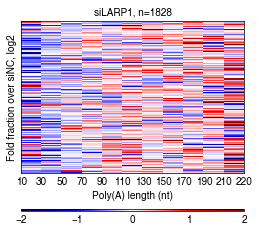

In [61]:
savefig = True
figsize = 4, 3.5
hierarchical_clustering= False
styles = ['../polya.mplstyle']

df_frac_ctrl = dfs[ctrl]
for smp in dfs:
    if smp == ctrl: continue
    df_frac = dfs[smp].copy()
    df_fold = np.log2(df_frac.div(df_frac_ctrl, axis='index').dropna())
    
    if hierarchical_clustering is True:
        X = np.array(df_fold)
        Z = linkage(X, "ward")
        D = dendrogram(Z)
        reordering_indices = df_fold.iloc[D['ivl']].index
        df_fold = df_fold.loc[reordering_indices]
    
    with plt.style.context(styles):
        fig, ax = plt.subplots(figsize=figsize)
        cmap = 'seismic'
        image = ax.pcolor(df_fold.iloc[:,:], vmin=-2, vmax=2, cmap=cmap, rasterized=True)


        # Adjust x-axis
        # xticklabels = edges + [pAlen_range[1]]
        xticklabels = edges
        ax.set_xticks(np.arange(len(xticklabels)))
        ax.set_xticklabels(xticklabels)
        ax.set_xlabel('Poly(A) length (nt)')

        # Adjust y-axis
        ax.set_yticks([])
        ax.set_ylabel(f'Fold fraction over {ctrl}, log2')

        # Adjust a colorbar
        # create an axes on the right side of ax. The width of cax will be (size)%
        # of ax and the padding between cax and ax will be fixed at 0.05 inch.
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("bottom", size="1.5%", pad=0.5)
        cbar = plt.colorbar(image, cax=cax, orientation="horizontal")
        cbar.solids.set_rasterized(True)

        ax.set_title(f"{smp.split('-')[0]}, n={len(df_fold)}", fontsize='medium')

        fname_adduct = ''

        if hierarchical_clustering is True:
            fname_adduct += '_hc_reordered'

        if savefig is True:
            outfigpath = "../plots/heatmap_fraction_fold_{}_{}_over_{}{}.pdf".format(work, smp, ctrl, fname_adduct)
            plt.savefig(outfigpath, dpi=300, bbox_inches='tight')
            print(outfigpath, 'saved')

        plt.show()


#### Modal poly(A) length scatter

In [59]:
smp = "NC2"

pAlen_range = [10, 220]; pr=pAlen_range
minimum_pAtags = 200
drop_mtgenes = True
np.random.seed(42)

pn = panels[smp].drop(mtgenes, errors="ignore") if drop_mtgenes else panels[smp]
pAtags = pn.sum(axis=2).iloc[pr[0]:pr[1]+1, :].T
pAtags = pAtags[pAtags.sum(axis=1) >= minimum_pAtags]
pAshuffled = pAtags.columns.tolist(); np.random.shuffle(pAshuffled)
pAmodes = pAtags[pAshuffled].apply(pd.Series.idxmax, axis=1)
pAmeans = pAtags.multiply(pAtags.columns).sum(axis=1) / pAtags.sum(axis=1) # Arithmatic mean

../plots/modal_vs_mean_pAlen_ms121_10-220_wo_mtgenes_mini.pdf


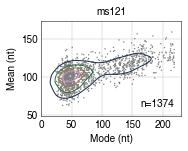

In [60]:
savefig = True
minifig = True

x = pAmodes
y = pAmeans

figsize = 5, 3.5

if minifig is True:
    styles.append("../mini.mplstyle")
    figsize = list(map(lambda x:x/2, figsize))
    
with plt.style.context(styles):

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    
    ax.scatter(x, y, s=2, color="grey", edgecolor="none", rasterized=True)
    sns.kdeplot(x, y, n_levels=5, cmap="cubehelix", ax=ax)
    
    ax.text(x=0.95, y=0.1, s="n=%d"%(len(x)), ha="right", transform=ax.transAxes)
    ax.set_xlim([0,230])
    ax.set_xticks(range(0,250,50))
    ax.set_xlabel("Mode (nt)")
    ax.set_ylabel("Mean (nt)")
    ax.set_title(work, fontsize="medium")
    ax.grid(True)

    fname_adduct = ""
    if drop_mtgenes is True: fname_adduct += "_wo_mtgenes"
    if minifig is True: fname_adduct += "_mini"

    if savefig is True:
        outfigpath = "../plots/modal_vs_mean_pAlen_{}_{}-{}{}.pdf".format(work, pr[0], pr[1], fname_adduct)
        print(outfigpath)
        fig.savefig(outfigpath, dpi=300, bbox_inches="tight")
        
    plt.show()

/utp/joha/miniconda3/envs/polya/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


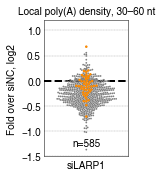

In [35]:
savefig = False
minifig = True
subsets = ['mtgenes', 'topgenes']
styles = ['../polya.mplstyle']
# non_ctrl = subsamples.copy()
# non_ctrl.pop(subsamples.index(ctrl))
non_ctrl=['siLARP1']
colors = ['gray'] + [colors_by_smp[subset] for subset in subsets]
figsize = 1.5 + 1.5*len(non_ctrl), 5
if minifig is True:
    if not minifig in styles: styles.append("../mini.mplstyle")
    figsize = list(map(lambda x:x/2, figsize))

with plt.style.context(styles):
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.axhline(y=0, ls='--', lw=2, alpha=1, color='black')
    
    # All genes but the subset
    df_rest = df_ld.drop(subset, errors='ignore')
    ax = sns.swarmplot(data=df_rest[non_ctrl], size=1.75, color='gray', ax=ax, rasterized=True)
    
    # The subset genes
    for si, subset in enumerate(subsets):
        subset_genes = gene_subsets[subset]
        ax = sns.swarmplot(data=df_ld.loc[subset_genes, non_ctrl], size=2.5, color=colors[si], ax=ax)

    ax.set_ylim([-1.5, 1.2])
    ax.set_ylabel(f"Fold over {ctrl}, log2")
    ax.set_title(f"Local poly(A) density, {lr[0]}–{lr[1]} nt", fontsize='medium')
    ax.grid(axis='y')

    for i, cnt in enumerate(nb_genes):
        ax.text(x=i, y=-1.3, s=f'n={cnt}', ha='center')

    fname_adduct = ""
    if minifig is True:
        fname_adduct += "_mini"

    if savefig is True:
        outfigpath = "/casa/joha/projects/polya/plots/local_pAd_folds_{}_{}-{}{}.pdf".format(work, lr[0], lr[1], fname_adduct)
        plt.savefig(outfigpath, bbox_inches='tight', dpi=300)
        print( outfigpath, 'saved')

    plt.show()